# MNIST digit classifier

## Loading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#copy reduced mnist data from drive and unzip it
!unzip /content/drive/MyDrive/ML-Assign-4/archive.zip

In [3]:
import glob
len(glob.glob('/content/Reduced MNIST Data/Reduced Testing data/*/*')),len(glob.glob('/content/Reduced MNIST Data/Reduced Trainging data/*/*'))

(2000, 10000)

### Training Le-Net-5

In [4]:
#imports
import glob
import cv2
import tqdm
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split

#setting random seed
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  random.seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  g = torch.Generator()
  g.manual_seed(seed)
  return g

In [5]:
#defining network
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=5*5*16, out_features=120),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.xavier_uniform_(m.weight.data)
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.xavier_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)


In [6]:
#defining data class
class data_set(Dataset):
    def __init__(self,test=False):
        if test:
          self.imgs_dir = glob.glob('/content/Reduced MNIST Data/Reduced Testing data/*/*')
        else:
          self.imgs_dir = glob.glob('/content/Reduced MNIST Data/Reduced Trainging data/*/*')
        self.transform_data = transforms.Compose([transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])

    def __len__(self):
        return len(self.imgs_dir)
  
    def __getitem__(self, index):
        img_dir = self.imgs_dir[index]
        label = int(img_dir.split('/')[-2])
        img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        img = self.transform_data(img)
        return img,label
        

In [7]:
#early stopping class
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0):

        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.patience:  
                self.early_stop = True

In [8]:
#training
#hyper-parameters values
startTime = time.time()

g = set_seed(0)

num_epochs = 80
lr = 0.02
weight_decay = 1e-5
batch_size = 64

#model, dataloader, optimizer, scheduler, cost function, early stopping
model = LeNet5()
model.apply(initialize_weights)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[8000,2000])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.15)

#training loop
train_loss_epochs = []
val_loss_epochs = []
stop_epoch = num_epochs
for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs)
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))
  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs)
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))

  early_stopping(np.mean(losses), np.mean(val_losses))
  if early_stopping.early_stop:
    print('-'*10," Early stopping ",'-'*10)
    stop_epoch = epoch + 1
    break

train_time = time.time() - startTime
print('training time: ',round(train_time,4),' s')


---------- Epoch :1/80 ----------
learning rate:  0.02
train loss:  0.5433745
validation loss:  0.25939193
---------- Epoch :2/80 ----------
learning rate:  0.02
train loss:  0.2019528
validation loss:  0.13938366
---------- Epoch :3/80 ----------
learning rate:  0.02
train loss:  0.14577691
validation loss:  0.14690898
---------- Epoch :4/80 ----------
learning rate:  0.02
train loss:  0.11880944
validation loss:  0.19681554
---------- Epoch :5/80 ----------
learning rate:  0.02
train loss:  0.14485052
validation loss:  0.18871187
---------- Epoch :6/80 ----------
learning rate:  0.02
train loss:  0.1250468
validation loss:  0.17930046
---------- Epoch :7/80 ----------
learning rate:  0.01
train loss:  0.06043309
validation loss:  0.14658497
---------- Epoch :8/80 ----------
learning rate:  0.01
train loss:  0.039323173
validation loss:  0.188017
---------- Epoch :9/80 ----------
learning rate:  0.01
train loss:  0.033132978
validation loss:  0.16482964
---------- Epoch :10/80 -------

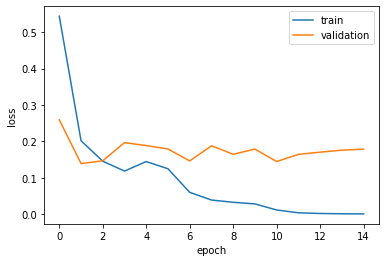

In [9]:
#plot loss
plt.plot(range(0,stop_epoch),train_loss_epochs)
plt.plot(range(0,stop_epoch),val_loss_epochs)

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'])

In [10]:
#tesing
startTime = time.time()

DataSet = data_set(test=True)
len_data = DataSet.__len__()
dataloader = DataLoader(DataSet, batch_size=batch_size, shuffle=True)
model.eval()

true_preds_tot = 0
for imgs,labels in dataloader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs)
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/len_data),'%')
test_time = time.time() - startTime
print('processing time: ',round(test_time,4),' s')

test accuracy:  98.1 %
processing time:  0.3725  s


### Training 3 variants of network

In [11]:
#re-defining network

#BatchNorm2d
class VarNet1(torch.nn.Module):
    def __init__(self):
        super(VarNet1, self).__init__()
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            torch.nn.BatchNorm2d(6),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=5*5*16, out_features=120),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

#adding dropout
class VarNet2(torch.nn.Module):
    def __init__(self):
        super(VarNet2, self).__init__()
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            torch.nn.Dropout(p=0.75),
            torch.nn.ReLU(),
            
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.Dropout(p=0.75),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=5*5*16, out_features=120),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x

#using maxpool
class VarNet3(torch.nn.Module):
    def __init__(self):
        super(VarNet3, self).__init__()
        self.conv_block1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_block = torch.nn.Sequential(
            torch.nn.Linear(in_features=16*5*5, out_features=120),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=10)
        )

    def forward(self,x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x



#### Variant 1: Using batch norm layers

In [12]:
#training
#hyper-parameters values
startTime = time.time()

g = set_seed(0)

num_epochs = 80
lr = 0.02
weight_decay = 1e-5
batch_size = 64

#model, dataloader, optimizer, scheduler, cost function, early stopping
model = VarNet1()
model.apply(initialize_weights)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[8000,2000])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.15)

#training loop
train_loss_epochs = []
val_loss_epochs = []
stop_epoch = num_epochs
for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs)
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))
  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs)
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))

  early_stopping(np.mean(losses), np.mean(val_losses))
  if early_stopping.early_stop:
    print('-'*10," Early stopping ",'-'*10)
    stop_epoch = epoch + 1
    break
train_time = time.time() - startTime
print('training time: ',round(train_time,4),' s')


---------- Epoch :1/80 ----------
learning rate:  0.02
train loss:  0.4914384
validation loss:  0.14125866
---------- Epoch :2/80 ----------
learning rate:  0.02
train loss:  0.16152617
validation loss:  0.10593723
---------- Epoch :3/80 ----------
learning rate:  0.02
train loss:  0.10748588
validation loss:  0.16183275
---------- Epoch :4/80 ----------
learning rate:  0.02
train loss:  0.09713488
validation loss:  0.11033717
---------- Epoch :5/80 ----------
learning rate:  0.02
train loss:  0.07802499
validation loss:  0.11847355
---------- Epoch :6/80 ----------
learning rate:  0.02
train loss:  0.07324106
validation loss:  0.13768819
---------- Epoch :7/80 ----------
learning rate:  0.01
train loss:  0.029728843
validation loss:  0.101703666
---------- Epoch :8/80 ----------
learning rate:  0.01
train loss:  0.0147679625
validation loss:  0.08032896
---------- Epoch :9/80 ----------
learning rate:  0.01
train loss:  0.015862854
validation loss:  0.12675406
---------- Epoch :10/80 

In [13]:
#tesing
startTime = time.time()

DataSet = data_set(test=True)
len_data = DataSet.__len__()
dataloader = DataLoader(DataSet, batch_size=batch_size, shuffle=True)
model.eval()

true_preds_tot = 0
for imgs,labels in dataloader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs)
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/len_data),'%')
test_time = time.time() - startTime
print('processing time: ',round(test_time,4),' s')

test accuracy:  98.45 %
processing time:  0.3424  s


#### Variant 2: Using drop out in conv blocks

In [14]:
#training
#hyper-parameters values
startTime = time.time()

g = set_seed(1)

num_epochs = 80
lr = 0.02
weight_decay = 1e-5
batch_size = 64

#model, dataloader, optimizer, scheduler, cost function, early stopping
model = VarNet2()
model.apply(initialize_weights)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[8000,2000])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.15)

#training loop
train_loss_epochs = []
val_loss_epochs = []
stop_epoch = num_epochs
for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs)
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))
  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs)
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))

  early_stopping(np.mean(losses), np.mean(val_losses))
  if early_stopping.early_stop:
    print('-'*10," Early stopping ",'-'*10)
    stop_epoch = epoch + 1
    break
train_time = time.time() - startTime
print('training time: ',round(train_time,4),' s')


---------- Epoch :1/80 ----------
learning rate:  0.02
train loss:  1.0838629
validation loss:  0.3014505
---------- Epoch :2/80 ----------
learning rate:  0.02
train loss:  0.56846994
validation loss:  0.22626108
---------- Epoch :3/80 ----------
learning rate:  0.02
train loss:  0.47642356
validation loss:  0.2591067
---------- Epoch :4/80 ----------
learning rate:  0.02
train loss:  0.48313656
validation loss:  0.1763419
---------- Epoch :5/80 ----------
learning rate:  0.02
train loss:  0.43608835
validation loss:  0.15194291
---------- Epoch :6/80 ----------
learning rate:  0.02
train loss:  0.44781515
validation loss:  0.17521209
---------- Epoch :7/80 ----------
learning rate:  0.02
train loss:  0.45547333
validation loss:  0.15991347
---------- Epoch :8/80 ----------
learning rate:  0.02
train loss:  0.42504826
validation loss:  0.16797191
---------- Epoch :9/80 ----------
learning rate:  0.02
train loss:  0.4492943
validation loss:  0.14940837
---------- Epoch :10/80 ---------

In [15]:
#tesing
startTime = time.time()

DataSet = data_set(test=True)
len_data = DataSet.__len__()
dataloader = DataLoader(DataSet, batch_size=batch_size, shuffle=True)
model.eval()

true_preds_tot = 0
for imgs,labels in dataloader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs)
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/len_data),'%')
test_time = time.time() - startTime
print('processing time: ',round(test_time,4),' s')

test accuracy:  98.35000000000001 %
processing time:  0.3268  s


#### Variant 3: Using max pool instead of avg pool

In [22]:
#training
#hyper-parameters values
startTime = time.time()

g = set_seed(0)

num_epochs = 80
lr = 0.02
weight_decay = 1e-5
batch_size = 64

#model, dataloader, optimizer, scheduler, cost function, early stopping
model = VarNet3()
model.apply(initialize_weights)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[8000,2000])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.15)

#training loop
train_loss_epochs = []
val_loss_epochs = []
stop_epoch = num_epochs
for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs)
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))
  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs)
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))

  early_stopping(np.mean(losses), np.mean(val_losses))
  if early_stopping.early_stop:
    print('-'*10," Early stopping ",'-'*10)
    stop_epoch = epoch + 1
    break
train_time = time.time() - startTime
print('training time: ',round(train_time,4),' s')


---------- Epoch :1/80 ----------
learning rate:  0.02
train loss:  0.65237755
validation loss:  0.21746261
---------- Epoch :2/80 ----------
learning rate:  0.02
train loss:  0.22864805
validation loss:  0.21179892
---------- Epoch :3/80 ----------
learning rate:  0.02
train loss:  0.19685012
validation loss:  0.22464813
---------- Epoch :4/80 ----------
learning rate:  0.02
train loss:  0.20004572
validation loss:  0.20933704
---------- Epoch :5/80 ----------
learning rate:  0.02
train loss:  0.17351887
validation loss:  0.200209
---------- Epoch :6/80 ----------
learning rate:  0.02
train loss:  0.17160477
validation loss:  0.21527569
---------- Epoch :7/80 ----------
learning rate:  0.02
train loss:  0.16932301
validation loss:  0.24762473
---------- Epoch :8/80 ----------
learning rate:  0.02
train loss:  0.16940044
validation loss:  0.277691
---------- Epoch :9/80 ----------
learning rate:  0.02
train loss:  0.16857508
validation loss:  0.218852
---------- Epoch :10/80 ----------

In [23]:
#tesing
startTime = time.time()

DataSet = data_set(test=True)
len_data = DataSet.__len__()
dataloader = DataLoader(DataSet, batch_size=batch_size, shuffle=True)
model.eval()

true_preds_tot = 0
for imgs,labels in dataloader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs)
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/len_data),'%')
test_time = time.time() - startTime
print('processing time: ',round(test_time,4),' s')

test accuracy:  96.95 %
processing time:  0.3327  s


## Training with data augmentation

#### Variant 4: Using Data augmentation

In [18]:
#defining data class
class data_set(Dataset):
    def __init__(self,test=False):
        if test:
          self.imgs_dir = glob.glob('/content/Reduced MNIST Data/Reduced Testing data/*/*')
        else:
          self.imgs_dir = glob.glob('/content/Reduced MNIST Data/Reduced Trainging data/*/*')
        self.transform_data = transforms.Compose([transforms.ToPILImage(),
                                                  transforms.RandomRotation(30),
                                                  transforms.RandomResizedCrop(28,(0.9,1)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize((0.5), (0.5))])

    def __len__(self):
        return len(self.imgs_dir)
  
    def __getitem__(self, index):
        img_dir = self.imgs_dir[index]
        label = int(img_dir.split('/')[-2])
        img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        img = self.transform_data(img)
        return img,label
        

In [19]:
#training
#hyper-parameters values
startTime = time.time()

g = set_seed(0)

num_epochs = 80
lr = 0.01
weight_decay = 1e-5
batch_size = 64

#model, dataloader, optimizer, scheduler, cost function, early stopping
model = LeNet5()
model.apply(initialize_weights)
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 3,factor=0.5)

DataSet = data_set()
train_DataSet, val_DataSet = random_split(DataSet,[8000,2000])
train_loader = DataLoader(train_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)
val_loader = DataLoader(val_DataSet, batch_size=batch_size, shuffle=True, drop_last=True, generator=g)

loss_fn = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, min_delta=0.05)

#training loop
train_loss_epochs = []
val_loss_epochs = []
stop_epoch = num_epochs
for epoch in range(0,num_epochs):
  print('-'*10,f"Epoch :{epoch+1}/{num_epochs}",'-'*10)
  print('learning rate: ',optimizer.param_groups[0]["lr"])
  #train
  losses=[]
  model.train()
  for imgs,labels in train_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #forward
    preds = model(imgs)
    #loss and backward
    optimizer.zero_grad()
    loss = loss_fn(preds,labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().cpu())
  print('train loss: ',np.mean(losses))
  train_loss_epochs.append(np.mean(losses))
  #validation
  val_losses=[]
  model.eval()
  for imgs,labels in val_loader:
    if torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    preds = model(imgs)
    val_loss = loss_fn(preds,labels)
    val_losses.append(val_loss.detach().cpu())
  scheduler.step(np.mean(val_losses))
  print('validation loss: ',np.mean(val_losses))
  val_loss_epochs.append(np.mean(val_losses))

  early_stopping(np.mean(losses), np.mean(val_losses))
  if early_stopping.early_stop:
    print('-'*10," Early stopping ",'-'*10)
    stop_epoch = epoch + 1
    break
train_time = time.time() - startTime
print('training time: ',round(train_time,4),' s')


---------- Epoch :1/80 ----------
learning rate:  0.01
train loss:  0.727655
validation loss:  0.32471663
---------- Epoch :2/80 ----------
learning rate:  0.01
train loss:  0.26831934
validation loss:  0.28205496
---------- Epoch :3/80 ----------
learning rate:  0.01
train loss:  0.2154825
validation loss:  0.23873456
---------- Epoch :4/80 ----------
learning rate:  0.01
train loss:  0.18702193
validation loss:  0.19272958
---------- Epoch :5/80 ----------
learning rate:  0.01
train loss:  0.17115384
validation loss:  0.17173827
---------- Epoch :6/80 ----------
learning rate:  0.01
train loss:  0.16619258
validation loss:  0.2168139
---------- Epoch :7/80 ----------
learning rate:  0.01
train loss:  0.16136166
validation loss:  0.18056837
---------- Epoch :8/80 ----------
learning rate:  0.01
train loss:  0.1477555
validation loss:  0.15273143
---------- Epoch :9/80 ----------
learning rate:  0.01
train loss:  0.14464276
validation loss:  0.19890048
---------- Epoch :10/80 ---------

In [20]:
#tesing
startTime = time.time()

g = set_seed(0)

DataSet = data_set(test=True)
len_data = DataSet.__len__()
dataloader = DataLoader(DataSet, batch_size=batch_size, shuffle=True, generator=g)
model.eval()

true_preds_tot = 0
for imgs,labels in dataloader:
  if torch.cuda.is_available():
    imgs = imgs.cuda()
    labels = labels.cuda()
  preds = model(imgs)
  true_preds = (torch.max(preds,axis=1).indices == labels).sum()
  true_preds_tot += true_preds
print('test accuracy: ',100*(true_preds_tot.cpu().numpy()/len_data),'%')
test_time = time.time() - startTime
print('processing time: ',round(test_time,4),' s')

test accuracy:  97.75 %
processing time:  1.0574  s
